# Churn Prediction - Hands-On Exercise

**Based on: DataCamp Supervised Learning Chapter 1**

This notebook walks you through applying classification concepts step-by-step.

---

## 🎯 Learning Objectives

By completing this notebook, you will:
1. Apply train-test split properly
2. Train multiple classification models
3. Evaluate using multiple metrics
4. Compare model performance
5. Make predictions on new data

---

## Step 1: Import Libraries

**Task**: Import all necessary libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Load Data

**Task**: Create a synthetic churn dataset for practice

In [2]:
from sklearn.datasets import make_classification

# Create synthetic churn data
X, y = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    weights=[0.75, 0.25],  # 25% churn rate
    random_state=42
)

# Create DataFrame
feature_names = [
    'account_length', 'international_plan', 'voice_mail_plan',
    'num_voice_messages', 'total_day_minutes', 'total_day_calls',
    'total_eve_minutes', 'total_night_minutes', 'total_intl_calls',
    'customer_service_calls'
]

df = pd.DataFrame(X, columns=feature_names)
df['churn'] = y

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (2000, 11)

First 5 rows:


,account_length,international_plan,voice_mail_plan,num_voice_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_night_minutes,total_intl_calls,customer_service_calls,churn
0,-0.401097,1.249961,-4.061954,2.346665,-2.532279,-0.975788,-0.449764,-0.361649,0.094370,1.090902,0
1,-2.253033,0.221874,-3.631354,0.398132,-5.032429,-0.530143,-2.202510,2.870743,2.309523,-1.153527,0
2,-5.085149,2.125224,-3.147242,1.264669,-5.274072,0.868469,0.118780,1.814647,0.779287,1.076528,0
3,-0.006076,-2.811426,-1.243174,0.055428,-2.682153,-1.460198,-1.257429,1.114618,1.225273,-1.407815,1
4,0.068853,0.023027,-0.872126,1.087298,2.515877,0.512387,0.954428,-0.110373,0.645181,1.058781,0


## Step 3: Exploratory Data Analysis

**Task**: Understand the dataset before modeling

### 3.1 Check class distribution

Churn Distribution:
No Churn (0): 1497 (74.9%)
Churn (1): 503 (25.1%)


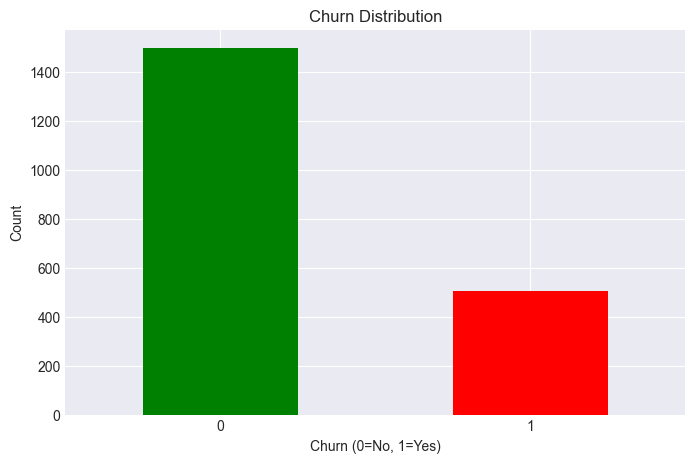

In [4]:
# YOUR CODE HERE:
# Calculate the percentage of churned vs non-churned customers
churn_counts = df['churn'].value_counts()
churn_pct = df['churn'].value_counts(normalize=True) * 100

print("Churn Distribution:")
print(f"No Churn (0): {churn_counts[0]} ({churn_pct[0]:.1f}%)")
print(f"Churn (1): {churn_counts[1]} ({churn_pct[1]:.1f}%)")

# Visualize
plt.figure(figsize=(8, 5))
churn_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# QUESTION: Is this dataset balanced or imbalanced? Why does it matter?
# ANSWER: The dataset is imbalanced, with 75% non-churned and 25% churned customers.
# This matters because imbalanced datasets can lead to biased models that perform poorly on the minority class

### 3.2 Feature Statistics

In [5]:
# YOUR CODE HERE:
# Display summary statistics for all features
df.describe().round(2)

,account_length,international_plan,voice_mail_plan,num_voice_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_night_minutes,total_intl_calls,customer_service_calls,churn
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,-1.43,-0.20,-0.29,0.98,-0.04,-0.03,0.76,0.23,-0.99,1.72,0.25
std,2.45,1.94,1.95,1.91,2.03,1.97,1.67,1.81,1.79,2.44,0.43
min,-9.96,-6.62,-7.26,-6.05,-8.36,-6.17,-5.80,-6.25,-6.34,-8.44,0.00
25%,-3.04,-1.61,-1.66,-0.32,-1.36,-1.35,-0.27,-1.01,-2.21,0.20,0.00
50%,-1.39,-0.13,-0.35,0.96,0.03,-0.06,0.79,0.28,-0.99,1.81,0.00
75%,0.19,1.16,1.00,2.31,1.35,1.33,1.86,1.48,0.22,3.31,1.00
max,6.49,5.72,6.27,7.09,6.26,7.32,6.78,5.38,6.83,9.35,1.00


## Step 4: Prepare Data

**Concept from DataCamp**: Always split data before training!

### 4.1 Separate features and target

In [6]:
# YOUR CODE HERE:
# Separate X (features) and y (target)
X = df.drop('churn', axis=1)
y = df['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (2000, 10)
Target shape: (2000,)


### 4.2 Train-Test Split

**Key Parameters**:
- `test_size`: Proportion for test set (typically 0.2 or 0.3)
- `random_state`: For reproducibility
- `stratify`: Maintains class distribution in both sets

In [7]:
# YOUR CODE HERE:
# Split the data with test_size=0.2, random_state=42, stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification worked
print(f"\nTraining set churn rate: {y_train.mean()*100:.1f}%")
print(f"Test set churn rate: {y_test.mean()*100:.1f}%")

# QUESTION: Why is stratification important?
# ANSWER: Stratification ensures that the class distribution in the training and test sets reflects that of the overall dataset. This is important for imbalanced datasets to ensure that both sets have a representative number of samples from each class, which helps in building and evaluating models effectively.

Training set: 1600 samples (80.0%)
Test set: 400 samples (20.0%)

Training set churn rate: 25.1%
Test set churn rate: 25.2%


### 4.3 Feature Scaling

**Why scale?** Some algorithms (Logistic Regression, KNN) are sensitive to feature magnitudes.

**Important**: Fit scaler on training data, then transform both train and test!

In [10]:
# YOUR CODE HERE:
# Create StandardScaler and fit_transform training data, transform test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled")
print(f"\nOriginal feature ranges:")
print(X_train.describe().loc[['min', 'max']].round(2))
print(f"\nScaled feature means (should be ~0):")
print(pd.DataFrame(X_train_scaled, columns=X.columns).mean().round(4))

 Features scaled

Original feature ranges:
     account_length  international_plan  voice_mail_plan  num_voice_messages  \
min           -9.96               -6.62            -7.26               -6.05   
max            6.49                5.72             6.27                7.09   

     total_day_minutes  total_day_calls  total_eve_minutes  \
min              -7.41            -6.17              -5.14   
max               6.26             7.32               6.78   

     total_night_minutes  total_intl_calls  customer_service_calls  
min                -6.25             -6.34                   -8.44  
max                 5.38              6.83                    9.35  

Scaled feature means (should be ~0):
account_length           -0.0
international_plan        0.0
voice_mail_plan           0.0
num_voice_messages       -0.0
total_day_minutes         0.0
total_day_calls           0.0
total_eve_minutes        -0.0
total_night_minutes      -0.0
total_intl_calls         -0.0
customer_servi

In [14]:
print(X_train_scaled[:5][:])
print(" First 5 rows of scaled features displayed")
print(X_test_scaled[:5][:])

[[ 1.10769067 -0.96691466  0.75893105 -0.42210853  0.28781222  0.08767211
  -2.0043719   0.57648785  0.03675754 -0.37341317]
 [ 0.32277927 -0.39243268 -0.54060898 -0.64251509 -0.24766025 -0.36321164
  -0.61309337  0.65812741  0.16671709 -0.52445426]
 [-0.12855316 -1.34249308 -1.42297575  0.85784989 -0.59188515 -1.67229941
  -1.31590121  1.95074386  0.09124247  0.48329514]
 [-0.04309242  0.32442547 -0.64170144  0.13254852 -0.30209457  0.70182709
  -0.06151275 -0.26482814  0.74003784 -0.24270393]
 [ 0.18760779  0.55144222 -0.60204689 -1.07071433 -1.04110613 -0.39741748
   0.66099178 -0.66032494  0.58395812 -1.31568564]]
 First 5 rows of scaled features displayed
[[ 0.0647247  -1.42489465  0.86469914 -0.80365372  0.28859666  0.25999582
   1.06778886 -0.82045421 -1.3480474   0.00909645]
 [-1.37972417 -1.7926095   0.07740937  1.50015006  0.50231464  0.76881124
   0.09705017  1.30314486  0.66660486  1.29498327]
 [-0.14808414  0.87798686  0.99008595  2.14782577 -0.99202383  2.14189588
  -1.65

## Step 5: Train Models

**Task**: Train 4 different classification models

### 5.1 Logistic Regression

In [15]:
# YOUR CODE HERE:
# Train Logistic Regression on SCALED data
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.3f}")

Logistic Regression Accuracy: 0.792


### 5.2 K-Nearest Neighbors

In [26]:
# YOUR CODE HERE:
# Train KNN with n_neighbors=5 on SCALED data
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.3f}")

KNN Accuracy: 0.917


### 5.3 Decision Tree

In [33]:
# YOUR CODE HERE:
# Train Decision Tree with max_depth=5 on UNSCALED data (trees don't need scaling)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.3f}")

Decision Tree Accuracy: 0.800


### 5.4 Random Forest

In [34]:
# YOUR CODE HERE:
# Train Random Forest with n_estimators=100, max_depth=5
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.3f}")

Random Forest Accuracy: 0.823


## Step 6: Evaluate Models

**Concept**: Accuracy alone is not enough! Use multiple metrics.

### 6.1 Calculate All Metrics

In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Calculate all metrics for a model"""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

# Evaluate all models
results = [
    evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, 'Logistic Regression'),
    evaluate_model(y_test, y_pred_knn, y_pred_proba_knn, 'K-Nearest Neighbors'),
    evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, 'Decision Tree'),
    evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest')
]

# Create comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# QUESTIONS:
# 1. Which model has the highest accuracy?
# K-Nearest Neighbors has the highest accuracy.
# 2. Which model has the highest recall? (important for catching churners)
# K-Nearest Neighbors has the highest recall.
# 3. Is there a model with high precision but low recall?
# Random Forest has relatively high precision but lower recall.


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression    0.7925   0.632353 0.425743  0.508876 0.764529
K-Nearest Neighbors    0.9175   0.877778 0.782178  0.827225 0.939568
      Decision Tree    0.8000   0.636364 0.485149  0.550562 0.808106
      Random Forest    0.8225   0.826087 0.376238  0.517007 0.877678


### 6.2 Confusion Matrix for Best Model

Best Model: K-Nearest Neighbors



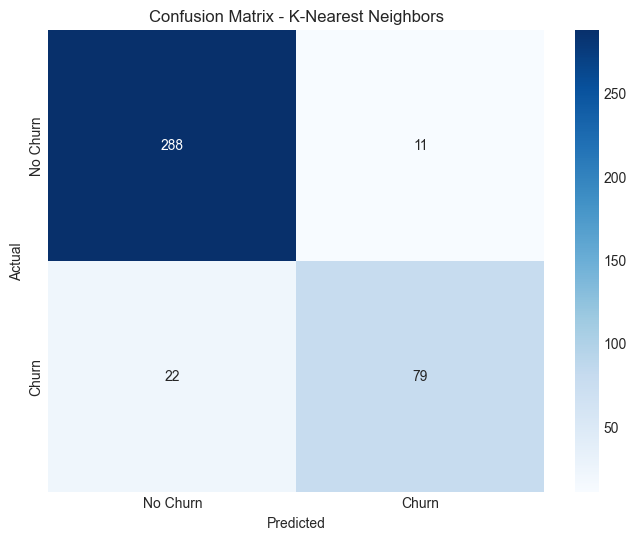


Confusion Matrix Breakdown:
True Negatives (correctly predicted no churn): 288
False Positives (incorrectly predicted churn): 11
False Negatives (missed churners): 22
True Positives (correctly predicted churn): 79


In [37]:
# Find best model by ROC-AUC
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"Best Model: {best_model_name}\n")

# Get predictions for best model
y_pred_best = y_pred_knn 

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Interpretation
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (correctly predicted no churn): {tn}")
print(f"False Positives (incorrectly predicted churn): {fp}")
print(f"False Negatives (missed churners): {fn}")
print(f"True Positives (correctly predicted churn): {tp}")

### 6.3 ROC Curve

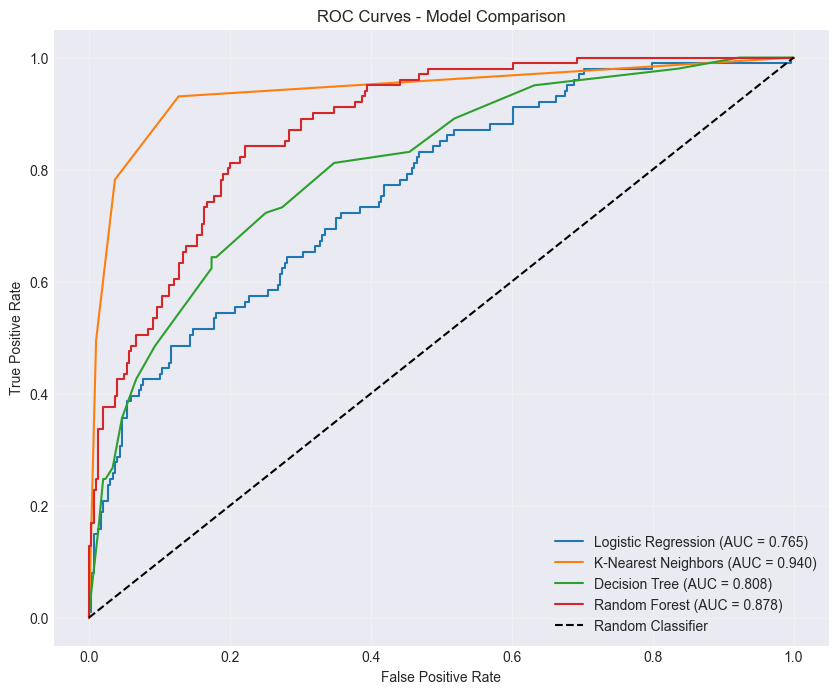

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

models_data = [
    ('Logistic Regression', y_pred_proba_lr),
    ('K-Nearest Neighbors', y_pred_proba_knn),
    ('Decision Tree', y_pred_proba_dt),
    ('Random Forest', y_pred_proba_rf)
]

for name, y_proba in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# QUESTION: What does the area under the ROC curve represent?
# ANSWER: The area under the ROC curve (AUC) represents the model's ability to distinguish between classes. A higher AUC indicates better performance, with 1.0 being a perfect classifier and 0.5 representing random guessing.

## Step 7: Make Predictions on New Data

**Task**: Use the best model to predict churn for new customers

In [39]:
# Create sample new customers
new_customers = pd.DataFrame({
    'account_length': [100, 150],
    'international_plan': [1, 0],
    'voice_mail_plan': [0, 1],
    'num_voice_messages': [20, 10],
    'total_day_minutes': [200, 150],
    'total_day_calls': [100, 80],
    'total_eve_minutes': [150, 120],
    'total_night_minutes': [100, 90],
    'total_intl_calls': [5, 2],
    'customer_service_calls': [3, 1]
})

print("New Customers:")
print(new_customers)

# Make predictions (use best model - assuming Random Forest)
predictions = rf_model.predict(new_customers)
probabilities = rf_model.predict_proba(new_customers)

print("\nPredictions:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"\nCustomer {i+1}:")
    print(f"  Prediction: {'CHURN' if pred == 1 else 'NO CHURN'}")
    print(f"  Churn Probability: {prob[1]:.1%}")
    print(f"  Confidence: {'High' if max(prob) > 0.8 else 'Medium' if max(prob) > 0.6 else 'Low'}")

New Customers:
   account_length  international_plan  voice_mail_plan  num_voice_messages  \
0             100                   1                0                  20   
1             150                   0                1                  10   

   total_day_minutes  total_day_calls  total_eve_minutes  total_night_minutes  \
0                200              100                150                  100   
1                150               80                120                   90   

   total_intl_calls  customer_service_calls  
0                 5                       3  
1                 2                       1  

Predictions:

Customer 1:
  Prediction: NO CHURN
  Churn Probability: 38.5%
  Confidence: Medium

Customer 2:
  Prediction: NO CHURN
  Churn Probability: 30.0%
  Confidence: Medium


## Step 8: Reflection Questions

Answer these to solidify your understanding:

1. **Why did we use train-test split?**
   - Answer: Train test split helps us train a model on majority of the data and use test data which model did not train on to evaluate models performance.

2. **Which metric is most important for churn prediction and why?**
   - Answer: ROC-AUC is most Important for churn pediction. As it indicates overall classifier performance and gives evaluation based on how good model can classify.

3. **What does a high false negative rate mean for the business?**
   - Answer: For churn prediction, the most important metric is Recall (or Sensitivity) for the “churn” class (Positive class).
Why?
A False Negative means:
Customer is actually going to churn → model says “No churn”.
This leads to lost revenue, because the company never reaches out to save that customer.
So businesses usually care more about:
Recall (catch all customers who will churn)
F1-score (balance of precision + recall)
Precision-Recall AUC (PR-AUC) when classes are imbalanced
ROC-AUC is useful, but Recall is more critical for churn.

4. **When would you choose Logistic Regression over Random Forest?**
   - Answer:Choose Logistic Regression when:
   You need interpretability
   LR provides coefficients, feature importance, and clear decision boundaries.
   Dataset is small or very clean
   LR performs well with fewer samples if features are meaningful.
   Business needs explainable decisions
   Telco, finance, insurance → often need interpretable and auditable models.
   Risk of overfitting must be low
   Random Forest can overfit without tuning. LR is simpler.

5. **How can we improve model performance?**
   - Answer: Hyperparameter tuning and Feature Engineering.

---

## 🎯 Next Steps

1. ✅ Complete all cells in this notebook
2. ✅ Try changing hyperparameters (max_depth, n_neighbors, etc.)
3. ✅ Experiment with different train-test split ratios
4. ✅ Add cross-validation to the evaluation
5. ✅ Save the best model using pickle
6. ✅ Create a simple Flask API for the model

---

## 💡 Key Takeaways

- Always split data before training
- Use multiple metrics, not just accuracy
- Understand the confusion matrix
- Choose metrics based on business context
- Different algorithms have different strengths
- Feature scaling matters for some algorithms